In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '34-resnet152'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_PATH = f'{COLAB_BASE_PATH}Submissions/{MODEL_NAME}.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [5]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [ ]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 256,
  "EPOCHS": 30,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "BASE_MODEL": 'resnet152',
  "BASE_MODEL_WEIGHTS": 'imagenet11k',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'resnet152',
 'BASE_MODEL_WEIGHTS': 'imagenet11k',
 'BATCH_SIZE': 256,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 30,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'WIDTH': 256}

# Load data

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-e12fcdd8602eaeb3e7343f4b322f78239cfa17e4bf5db65058b851ad' # KaggleDatasets().get_gcs_path(config['DATASET_PATH'])
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    data['diagnosis'] = tf.cast(tf.one_hot(example['diagnosis'], 10), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.000297 to 1.16e-05


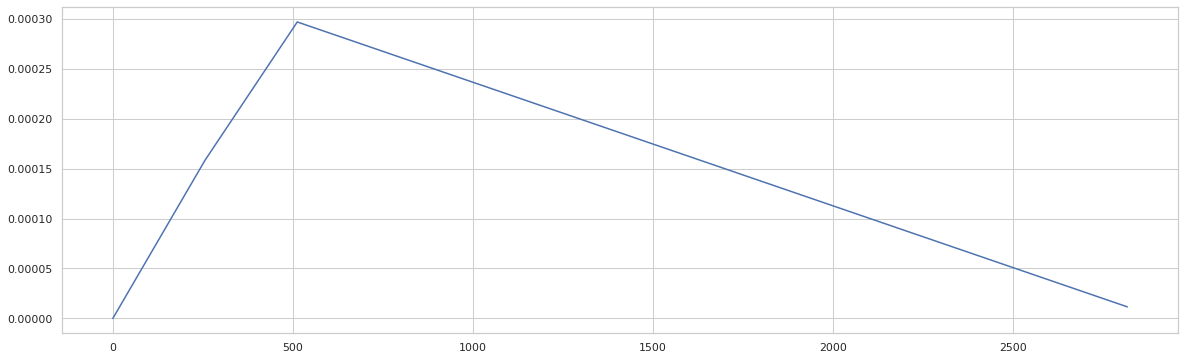

In [11]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [12]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    BaseModel, preprocess_input = Classifiers.get(config['BASE_MODEL'])
    base_model = BaseModel(input_shape=input_shape, 
                           weights=config['BASE_MODEL_WEIGHTS'], 
                           include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [13]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(len(k_fold)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        train_size = count_data_items(train_filenames)

        step_size = train_size // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=True, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                     total_steps=total_steps, warmup_steps=warmup_steps, 
                                                     hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                     lr_max=lr_max, lr_min=lr_min)

            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=step_size,
                            callbacks=[checkpoint, es], 
                            class_weight={0: 0.5089, 1: 28.3613},
                            verbose=2).history

        history_list.append(history)

        # Make predictions
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


234332160/234326024 [==============================] - 3s 0us/step
Epoch 1/30
97/97 - 73s - loss: 0.5868 - auc: 0.7932 - val_loss: 0.4528 - val_auc: 0.4989
Epoch 2/30
97/97 - 52s - loss: 0.5814 - auc: 0.8077 - val_loss: 0.1735 - val_auc: 0.5337
Epoch 3/30
97/97 - 41s - loss: 0.5227 - auc: 0.8355 - val_loss: 0.2274 - val_auc: 0.3713
Epoch 4/30
97/97 - 41s - loss: 0.5072 - auc: 0.8482 - val_loss: 0.2685 - val_auc: 0.5000
Epoch 5/30
97/97 - 41s - loss: 0.4985 - auc: 0.8518 - val_loss: 2.4447 - val_auc: 0.4324
Epoch 6/30
97/97 - 41s - loss: 0.4937 - auc: 0.8558 - val_loss: 0.4428 - val_auc: 0.7330
Epoch 7/30
97/97 - 41s - loss: 0.4710 - auc: 0.8668 - val_loss: 0.1785 - val_auc: 0.5191
Epoch 8/30
97/97 - 41s - loss: 0.4799 - auc: 0.8696 - val_loss: 0.4495 - val_auc: 0.7470
Epoch 9/30
97/97 - 51s - loss: 0.4668 - auc: 0.8736 - val_loss: 0.1688 - val_auc: 0.8255
Epoch 10/30
97/97 - 42s - loss: 0.4645 - auc: 0.8762 - val_loss: 0.4238 - val_auc: 0.7992
Epoch 11/30
97/97 - 42s - loss: 0.4517 - a

INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
105/105 - 75s - loss: 0.6908 - auc: 0.7333 - val_loss: 0.2280 - val_auc: 0.4826
Epoch 2/30
105/105 - 43s - loss: 0.5811 - auc: 0.7911 - val_loss: 4.9112 - val_auc: 0.4798
Epoch 3/30
105/105 - 43s - loss: 0.5046 - auc: 0.8447 - val_loss: 0.9525 - val_auc: 0.7043
Epoch 4/30
105/105 - 43s - loss: 0.5266 - auc: 0.8316 - val_loss: 4.0785 - val_auc: 0.4672
Epoch 5/30
105/105 - 43s - loss: 0.5386 - auc: 0.8255 - val_loss: 0.6321 - val_auc: 0.5809
Epoch 6/30
105/105 - 53s - loss: 0.5602 - auc: 0.8034 - val_loss: 0.1946 - val_auc: 0.6404
Epoch 7/30
105/105 - 53s - loss: 0.5604 - auc: 0.7832 - val_loss: 0.1733 - val_auc: 0.7733
Epoch 8/30
105/105 - 53s - loss: 0.5360 - auc: 0.8109 - val_loss: 0.1733 - val_auc: 0.7703
Epoch 9/30
105/105 - 43s - loss: 0.5090 - auc: 0.8332 - val_loss: 0.1994 - val_auc: 0.7406
Epoch 10/30
105/105 - 43s - loss: 0.5063 - auc: 0.8396 - val_loss: 1.3966 - val_auc: 0.7425
Epoch 11/30
105/105 - 43s - loss: 0.5218 - auc: 0.8314 - val_loss: 0.4769 - val_auc: 0.81

INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
105/105 - 76s - loss: 0.5868 - auc: 0.7901 - val_loss: 1.1374 - val_auc: 0.5448
Epoch 2/30
105/105 - 43s - loss: 0.5941 - auc: 0.7902 - val_loss: 3.2357 - val_auc: 0.4245
Epoch 3/30
105/105 - 53s - loss: 0.5115 - auc: 0.8360 - val_loss: 0.4050 - val_auc: 0.3834
Epoch 4/30
105/105 - 53s - loss: 0.5188 - auc: 0.8310 - val_loss: 0.2487 - val_auc: 0.3848
Epoch 5/30
105/105 - 43s - loss: 0.5401 - auc: 0.8190 - val_loss: 116.4496 - val_auc: 0.5811
Epoch 6/30
105/105 - 43s - loss: 0.5334 - auc: 0.8132 - val_loss: 1.2437 - val_auc: 0.7312
Epoch 7/30
105/105 - 53s - loss: 0.5053 - auc: 0.8363 - val_loss: 0.1721 - val_auc: 0.7704
Epoch 8/30
105/105 - 43s - loss: 0.5114 - auc: 0.8427 - val_loss: 0.1759 - val_auc: 0.7947
Epoch 9/30
105/105 - 43s - loss: 0.4780 - auc: 0.8603 - val_loss: 0.6650 - val_auc: 0.8382
Epoch 10/30
105/105 - 46s - loss: 0.4777 - auc: 0.8578 - val_loss: 0.1910 - val_auc: 0.8431
Epoch 11/30
105/105 - 43s - loss: 0.4962 - auc: 0.8500 - val_loss: 0.7121 - val_auc: 0.

INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
105/105 - 74s - loss: 0.6319 - auc: 0.7593 - val_loss: 0.5129 - val_auc: 0.4832
Epoch 2/30
105/105 - 43s - loss: 0.5462 - auc: 0.8179 - val_loss: 3.8590 - val_auc: 0.4769
Epoch 3/30
105/105 - 53s - loss: 0.5164 - auc: 0.8353 - val_loss: 0.1775 - val_auc: 0.4980
Epoch 4/30
105/105 - 43s - loss: 0.5101 - auc: 0.8360 - val_loss: 0.1786 - val_auc: 0.5649
Epoch 5/30
105/105 - 43s - loss: 0.5217 - auc: 0.8272 - val_loss: 0.6789 - val_auc: 0.5000
Epoch 6/30
105/105 - 43s - loss: 0.5604 - auc: 0.7965 - val_loss: 0.2444 - val_auc: 0.7438
Epoch 7/30
105/105 - 43s - loss: 0.5368 - auc: 0.8190 - val_loss: 1.5985 - val_auc: 0.7476
Epoch 8/30
105/105 - 44s - loss: 0.5084 - auc: 0.8366 - val_loss: 1.2065 - val_auc: 0.7492
Epoch 9/30
105/105 - 43s - loss: 0.4968 - auc: 0.8511 - val_loss: 3.5714 - val_auc: 0.7653
Epoch 10/30
105/105 - 43s - loss: 0.4934 - auc: 0.8522 - val_loss: 0.1931 - val_auc: 0.8104
Epoch 11/30
105/105 - 43s - loss: 0.4676 - auc: 0.8704 - val_loss: 0.2909 - val_auc: 0.85

INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
105/105 - 75s - loss: 0.6574 - auc: 0.7797 - val_loss: 1.0539 - val_auc: 0.3426
Epoch 2/30
105/105 - 53s - loss: 0.5813 - auc: 0.8031 - val_loss: 0.1893 - val_auc: 0.5866
Epoch 3/30
105/105 - 43s - loss: 0.5375 - auc: 0.8242 - val_loss: 0.2021 - val_auc: 0.4067
Epoch 4/30
105/105 - 43s - loss: 0.5027 - auc: 0.8446 - val_loss: 1.6225 - val_auc: 0.3055
Epoch 5/30
105/105 - 44s - loss: 0.4956 - auc: 0.8496 - val_loss: 0.8583 - val_auc: 0.3075
Epoch 6/30
105/105 - 53s - loss: 0.5102 - auc: 0.8392 - val_loss: 0.1711 - val_auc: 0.7601
Epoch 7/30
105/105 - 44s - loss: 0.5077 - auc: 0.8417 - val_loss: 0.3911 - val_auc: 0.7959
Epoch 8/30
105/105 - 43s - loss: 0.4922 - auc: 0.8533 - val_loss: 0.6836 - val_auc: 0.7855
Epoch 9/30
105/105 - 43s - loss: 0.4800 - auc: 0.8591 - val_loss: 1.1357 - val_auc: 0.8348
Epoch 10/30
105/105 - 43s - loss: 0.4834 - auc: 0.8631 - val_loss: 0.1980 - val_auc: 0.8826
Epoch 11/30
105/105 - 43s - loss: 0.4617 - auc: 0.8775 - val_loss: 0.1961 - val_auc: 0.85

## Model loss graph

Fold: 1


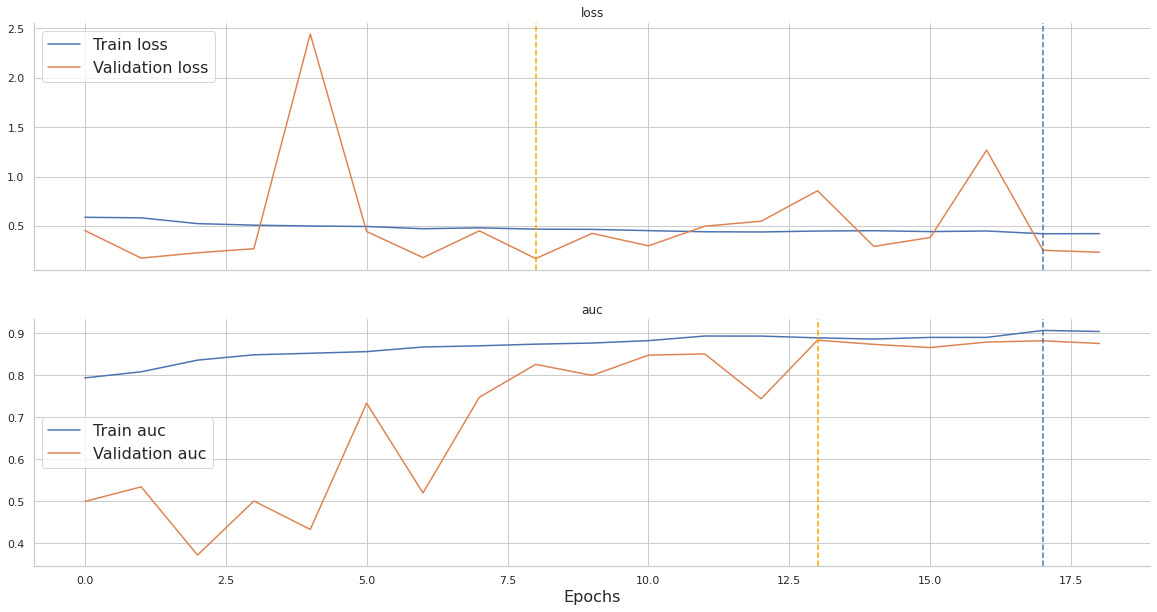

Fold: 2


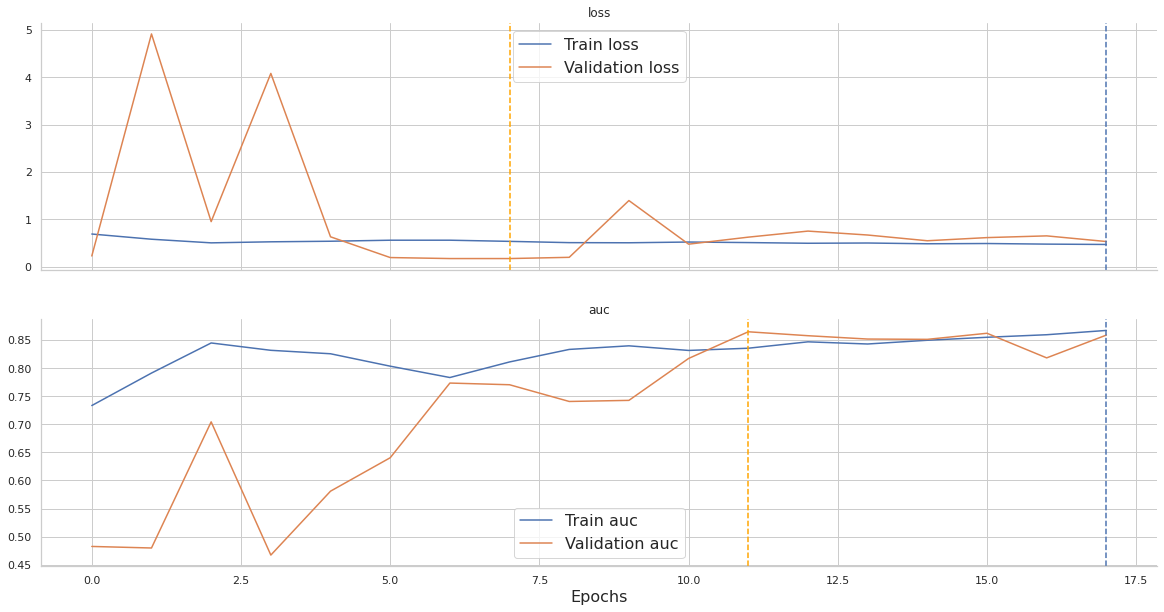

Fold: 3


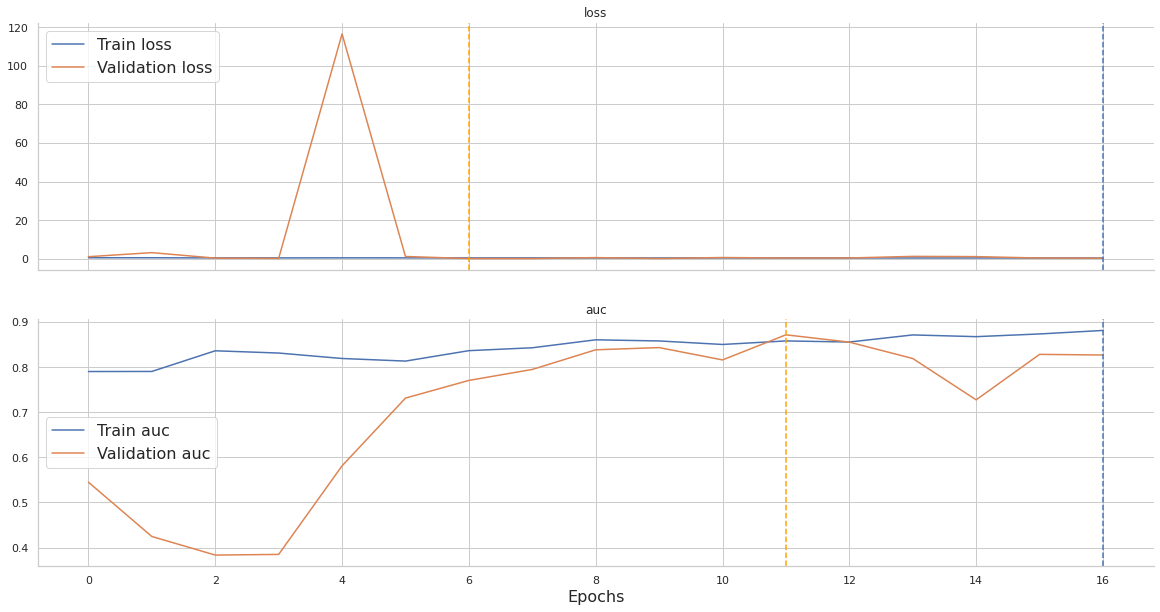

Fold: 4


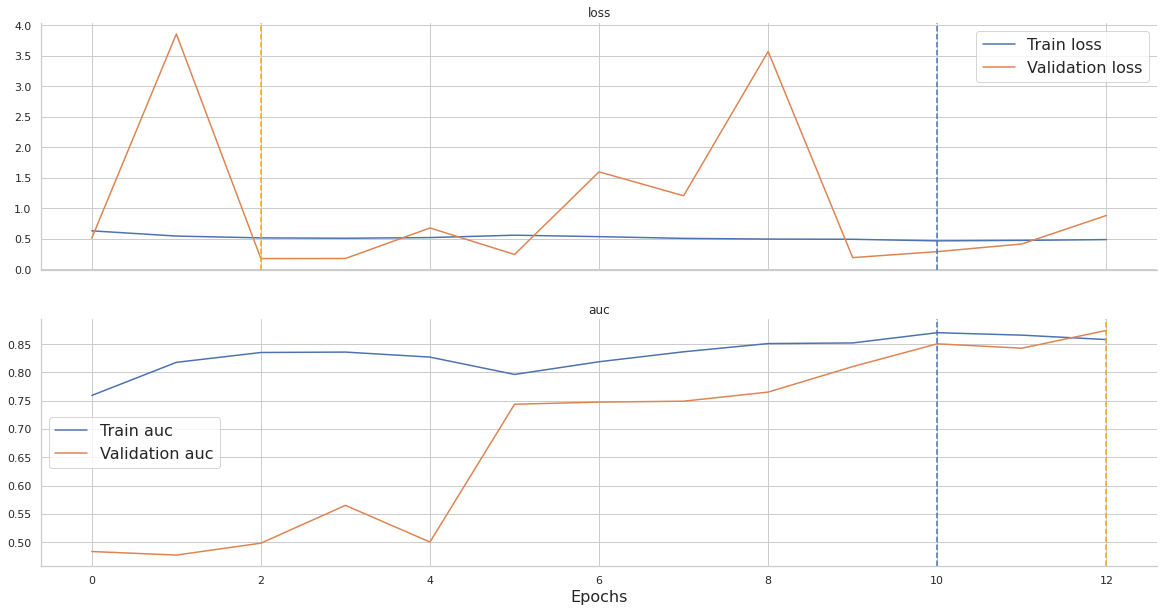

Fold: 5


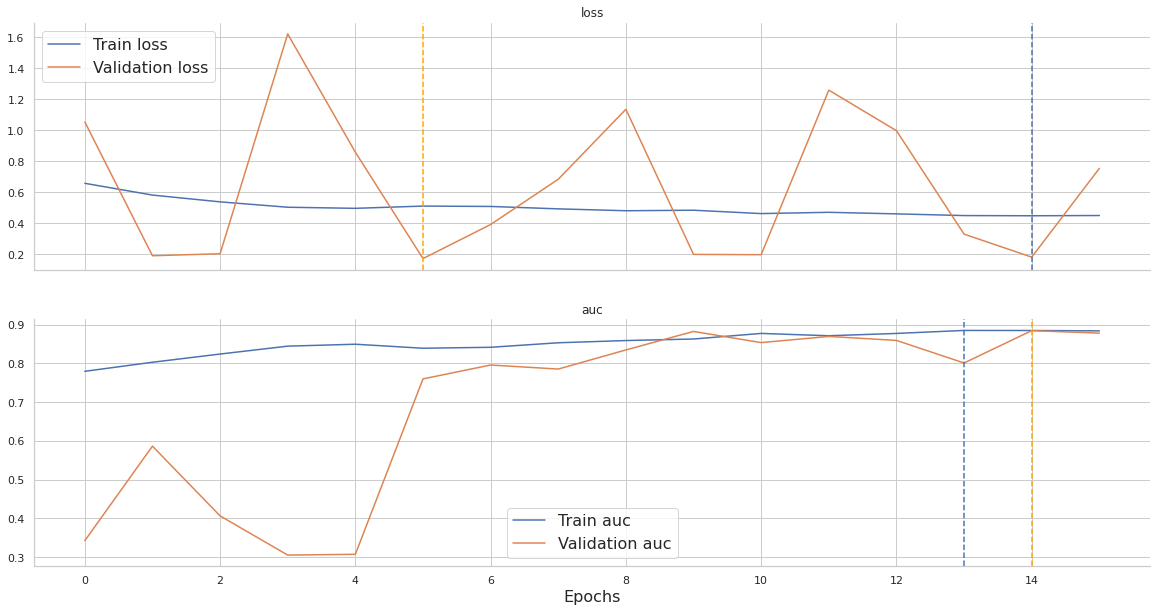

In [14]:
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

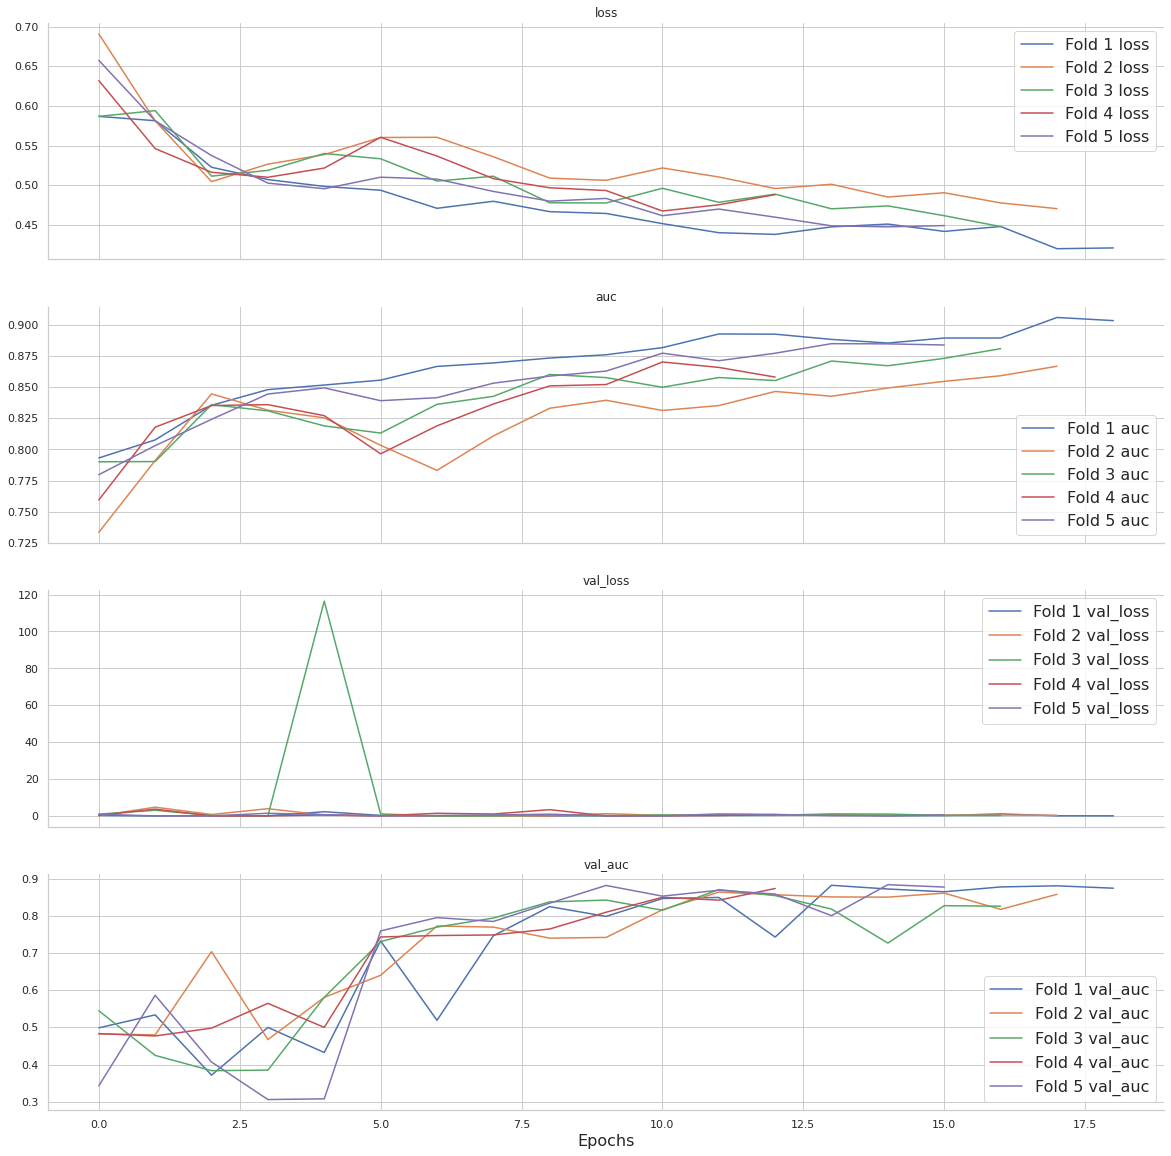

In [15]:
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [16]:
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.724695,0.722104,0.002591,0.846342,0.825452,0.784769,0.772020,0.770058,0.773276,0.473066,0.469717,0.749242,0.770055
Accuracy,0.982337,0.982305,0.000032,0.982167,0.982859,0.982239,0.982295,0.982499,0.981812,0.982469,0.981944,0.982313,0.982617
Precision,0.050000,0.000000,0.050000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall,0.000844,0.000000,0.000844,0.000000,0.000000,0.004219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F1-score,0.001660,0.000000,0.001660,0.000000,0.000000,0.008299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


# Model evaluation by Subset

In [17]:
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.724695,0.722104,0.002591,0.846342,0.825452,0.784769,0.772020,0.770058,0.773276,0.473066,0.469717,0.749242,0.770055
male,0.725804,0.718323,0.007481,0.839214,0.841559,0.781304,0.750913,0.765204,0.760661,0.503815,0.484861,0.739484,0.753620
female,0.721975,0.725730,-0.003754,0.852022,0.799731,0.784551,0.803042,0.773145,0.781784,0.445615,0.458075,0.754543,0.786017
head/neck,0.683152,0.680609,0.002543,0.768375,0.813488,0.700173,0.676880,0.650195,0.651084,0.590016,0.520231,0.707002,0.741362
upper extremity,0.713961,0.672797,0.041164,0.829864,0.814763,0.774775,0.759159,0.747732,0.717262,0.449989,0.347385,0.767444,0.725417
lower extremity,0.729376,0.742930,-0.013554,0.861344,0.790410,0.784661,0.761053,0.789826,0.822727,0.480980,0.591148,0.730067,0.749313
torso,0.729093,0.738986,-0.009893,0.853188,0.853830,0.815879,0.821822,0.782217,0.772723,0.424043,0.429731,0.770138,0.816823
0 <= age < 26,0.753745,0.762475,-0.008730,0.892126,0.889510,0.844697,0.720418,0.749319,0.788969,0.540037,0.699563,0.742545,0.713914
26 <= age < 40,0.721133,0.786714,-0.065581,0.868189,0.832825,0.768560,0.813967,0.794563,0.784290,0.465762,0.703224,0.708590,0.799264


# Confusion matrix

Fold: 1


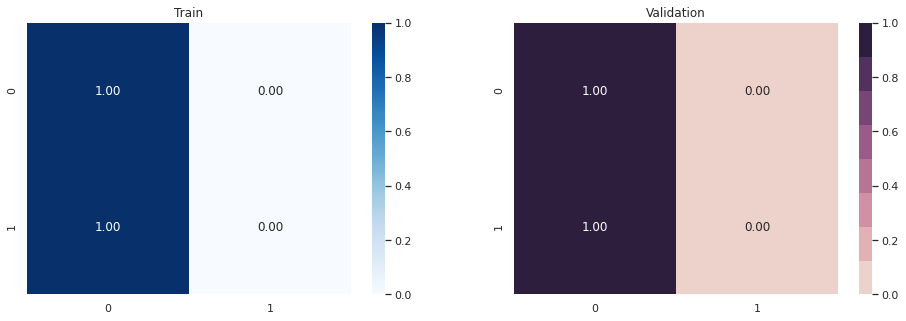

Fold: 2


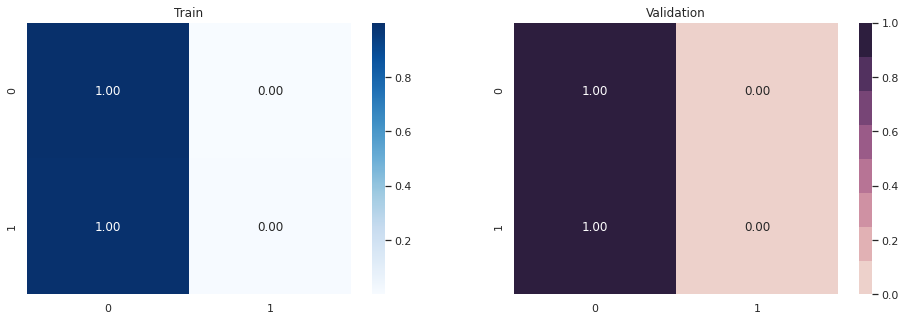

Fold: 3


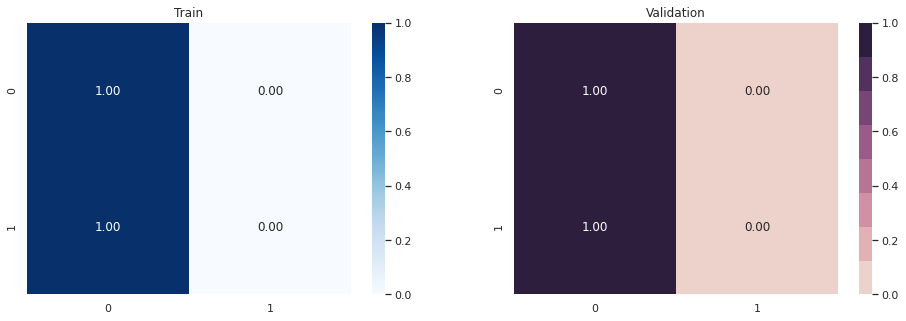

Fold: 4


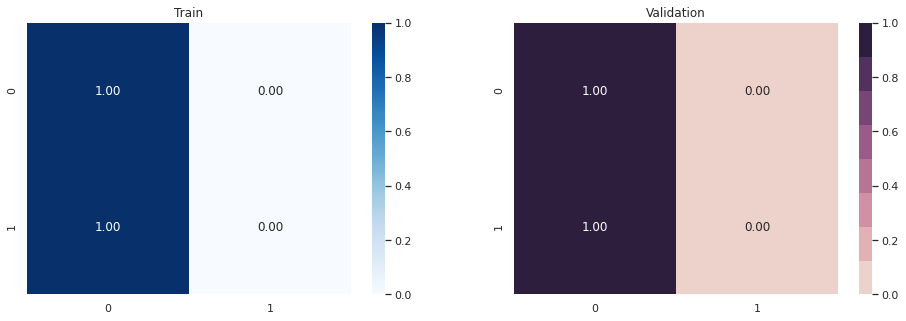

Fold: 5


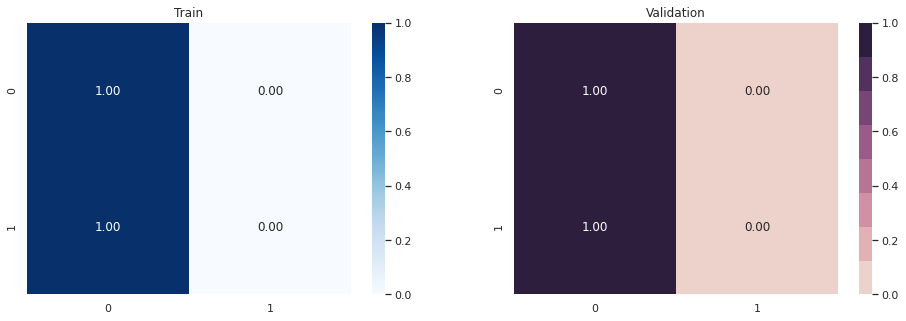

In [18]:
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [19]:
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.049605,0.056722,0.026680,0.077234,0.063883,0.023506
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.038541,0.017324,0.043218,0.037219,0.061037,0.033908
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.038184,0.047874,0.033803,0.025433,0.059351,0.024460
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.055372,0.026798,0.098385,0.068049,0.059590,0.024038
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.033878,0.017475,0.028031,0.033849,0.060259,0.029774
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.031436,0.018963,0.025646,0.029394,0.057185,0.025992
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.035793,0.021014,0.032631,0.027248,0.062224,0.035849
7,ISIC_0075663,female,35.0,torso,unknown,0,0.069226,0.057681,0.135032,0.048246,0.058518,0.046653
8,ISIC_0075914,male,30.0,torso,unknown,0,0.031121,0.022975,0.022314,0.022177,0.060335,0.027803
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.035731,0.036729,0.025831,0.032414,0.059797,0.023885


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.035726,0.023424,0.028187,0.039469,0.058722,0.028827
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.078664,0.096857,0.064527,0.115917,0.060824,0.055194
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.073153,0.134699,0.062638,0.081873,0.055704,0.030852
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.053779,0.059088,0.059913,0.037600,0.055467,0.056825
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.051294,0.062363,0.033704,0.069926,0.058403,0.032075
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.046119,0.063672,0.042338,0.028619,0.061102,0.034861
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.071802,0.144825,0.070977,0.051894,0.056234,0.035079
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.057216,0.135224,0.039411,0.025372,0.058149,0.027922
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.071035,0.101702,0.123281,0.035017,0.057274,0.037902
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.089031,0.113983,0.041626,0.164667,0.057741,0.067139


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 0
Train positive correct predictions: 0


# Make predictions

In [20]:
model_path_list = glob.glob(MODEL_BASE_PATH + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

5 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/34-resnet152/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/34-resnet152/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/34-resnet152/model_fold_3.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/34-resnet152/model_fold_4.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/34-resnet152/model_fold_5.h5


In [21]:
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset) / n_models


image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/34-resnet152/model_fold_1.h5


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/34-resnet152/model_fold_2.h5


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/34-resnet152/model_fold_3.h5


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/34-resnet152/model_fold_4.h5


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.143.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/34-resnet152/model_fold_5.h5


# Visualize test predictions

In [22]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge','target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 0|10982
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0052060,male,70.0,NaN,0.031114
1,ISIC_0052349,male,40.0,lower extremity,0.034033
2,ISIC_0058510,female,55.0,torso,0.030627
3,ISIC_0073313,female,50.0,torso,0.027693
4,ISIC_0073502,female,45.0,lower extremity,0.041378
5,ISIC_0074618,male,50.0,lower extremity,0.040048
6,ISIC_0076801,male,45.0,upper extremity,0.041874
7,ISIC_0077586,male,50.0,lower extremity,0.044258
8,ISIC_0082004,female,45.0,torso,0.044326
9,ISIC_0082785,male,65.0,lower extremity,0.046998


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target


# Test set predictions

In [23]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission.to_csv(SUBMISSION_PATH, index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
0,ISIC_0052060,0.031114
1,ISIC_0052349,0.034033
2,ISIC_0058510,0.030627
3,ISIC_0073313,0.027693
4,ISIC_0073502,0.041378
5,ISIC_0074618,0.040048
6,ISIC_0076801,0.041874
7,ISIC_0077586,0.044258
8,ISIC_0082004,0.044326
9,ISIC_0082785,0.046998


,target
count,10982.000000
mean,0.047237
std,0.019969
min,0.023903
25%,0.034126
50%,0.041380
75%,0.053182
max,0.266065
